In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb  8 12:38:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P8    N/A /  N/A |     40MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2022-02-08 12:38:35 +01:00)


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

time: 15 ms (started: 2022-02-08 12:38:40 +01:00)


In [4]:
! pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=d167c63f4ad8e960f148b07819e628c41ffa2b65b2d439fb05a05ea2801663ab
  Stored in directory: c:\users\sioha\appdata\local\pip\cache\wheels\14\98\74\190efced439ab92ca551550906290338ba5b64cfc9d0927765
Successfully built bayesian-optimization
time: 5.44 s (started: 2022-02-08 12:39:16 +01:00)


In [5]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Activation,Input,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

time: 22.8 s (started: 2022-02-08 12:39:42 +01:00)


In [6]:
#define directory path => adapted to my laptop
root_dir ='C:/Users/sioha/Projet_mushroom/' #project folder path
raw_data_dir = root_dir + 'RAW DATA/' #raw images folder
DL_dir = root_dir + 'Deep_learning/' #Deep Learning folder

# export dir with time stamp to save the results of the Deep Learning
#timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
#export_dir = DL_dir + timestamp + '/'
#os.makedirs(export_dir)
#print(str(export_dir))

time: 0 ns (started: 2022-02-08 12:43:24 +01:00)


In [7]:
print('*'*115)
print('*'*115)

*******************************************************************************************************************
*******************************************************************************************************************
time: 0 ns (started: 2022-02-08 12:43:28 +01:00)


In [17]:
random_seed = 42 # for random_state in the train_test_split 
resol = (240, 320) #images dimensions (height,width)
family_number = 7 # number of family to keep
number_of_images = 5000 # None to get all images 
epochs = 10 # epoch 
learning_rate = 0.001 # a learning rate of 0.001 is often used / working
batch_size = 128 # batch size
base_model_trainable = False # base model trainable

time: 0 ns (started: 2022-02-08 12:48:51 +01:00)


In [18]:
print('*'*115)

*******************************************************************************************************************
time: 0 ns (started: 2022-02-08 12:48:54 +01:00)


ImageDataGenerator

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_data_generator=ImageDataGenerator(rotation_range=50,width_shift_range=0.2,height_shift_range=0.2,
                                        horizontal_flip=True,validation_split=0.2)
test_data_generator=ImageDataGenerator()

time: 0 ns (started: 2022-02-08 12:48:59 +01:00)


In [20]:
training_data=train_data_generator.flow_from_directory(directory=root_dir+'5000_imgs_for_DL/Train/',
                                                       target_size=(240,320),class_mode='sparse',
                                                       batch_size=128,subset="training")
validation_data=train_data_generator.flow_from_directory(directory=root_dir+'5000_imgs_for_DL/Train/',
                                                       target_size=(240,320),class_mode='sparse',
                                                       batch_size=128,subset="validation")
test_data=test_data_generator.flow_from_directory(directory=root_dir+'5000_imgs_for_DL/Test/',
                                                  target_size=(240,320),class_mode='sparse',
                                                  batch_size=128)

Found 3203 images belonging to 7 classes.
Found 797 images belonging to 7 classes.
Found 1000 images belonging to 7 classes.
time: 625 ms (started: 2022-02-08 12:49:35 +01:00)


AFFICHAGE DE 4 IMAGES ORIGINALES + LEURS MODIFICATIONS AVEC ImageDataGenerator

In [21]:
family_dirs = [f.path for f in os.scandir(root_dir+'5000_imgs_for_DL/Train') if f.is_dir()]
display(family_dirs)

['C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Agaricaceae',
 'C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Amanitaceae',
 'C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Boletaceae',
 'C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Cortinariaceae',
 'C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Russulaceae',
 'C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Strophariaceae',
 'C:/Users/sioha/Projet_mushroom/5000_imgs_for_DL/Train\\Tricholomataceae']

time: 16 ms (started: 2022-02-08 12:50:16 +01:00)


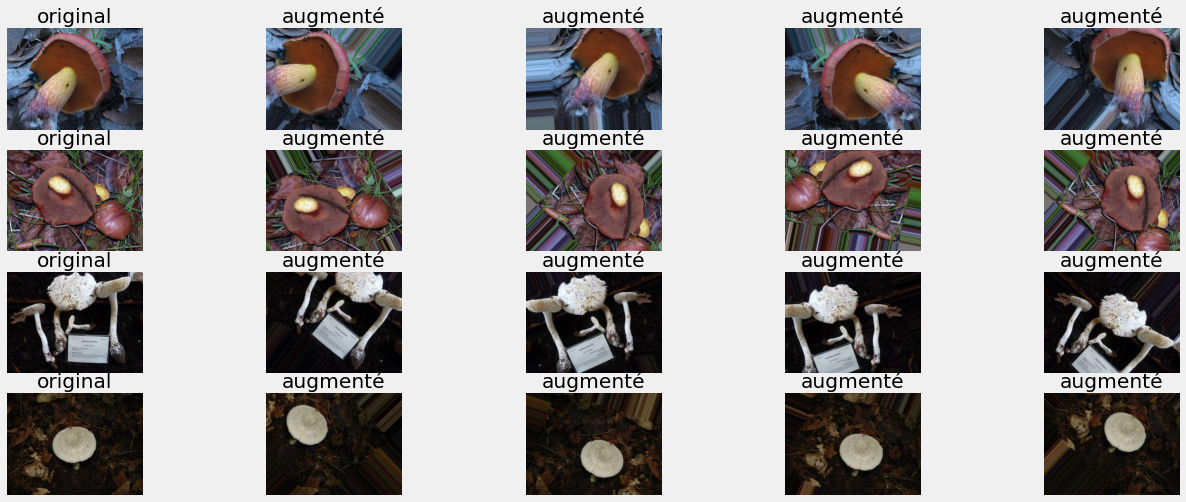

time: 5.12 s (started: 2022-02-08 12:53:08 +01:00)


In [23]:
#sélection aléatoire parmi les 1000 images de Test
fig,axs=plt.subplots(4,5,figsize=(20,8))
batch=np.random.randint(7) #last batch n°8 not included as there is only 104 images in this group
for row in range(4):
    indice=np.random.randint(128) #random selection among the 128 images of the batch
    im=np.array(test_data[batch][0][indice],dtype=np.uint8)
#    im=io.imread(df['file_path'].iloc[indice])
    axs[row,0].imshow(im)
    axs[row,0].set_title('original')
    axs[row,0].axis('off')
    for col in range(1,5):
        im_gen=train_data_generator.random_transform(im)
        axs[row,col].imshow(im_gen)
        axs[row,col].set_title('augmenté')
        axs[row,col].axis('off')

In [24]:
print('*'*115)

*******************************************************************************************************************
time: 0 ns (started: 2022-02-08 12:53:22 +01:00)


FUNCTIONS DEFINITION

Function "define_model" to create the model with a model_name and a base_model such as the VGG19

In [25]:
#Function "plot_history"
def plot_history(model_history):
    train_acc_model = model_history.history['accuracy']
    val_acc_model = model_history.history['val_accuracy']  

    fig = plt.figure(figsize=(20,5))
    plt.subplot(121) #loss & val_loss results versus epochs
    plt.plot(range(len(model_history.history['loss'])), model_history.history['loss'],
             '-o', label = "training")
    plt.plot(range(len(model_history.history['val_loss'])), model_history.history['val_loss'],
             '-o',label = "validation")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss versus epoch")
    plt.legend()

    plt.subplot(122) #accuracy & val_accuracy versus epochs
    plt.plot(range(len(model_history.history['accuracy'])), model_history.history['accuracy'],
             '-o', label = "training")
    plt.plot(range(len(model_history.history['val_accuracy'])), model_history.history['val_accuracy'],
             '-o',label = "validation")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy versus epoch")
    plt.legend();
    fig.suptitle(pathinfos + '_training history',size = 20)
    fig.subplots_adjust(top=0.8)
    plt.close()
    return fig

time: 0 ns (started: 2022-02-08 12:53:31 +01:00)


In [26]:
#Function to plot a colored confusion matrix
def conf_matrix(y_test_class , test_pred_class,classes,df_label):
    cnf_matrix = np.around(confusion_matrix(y_test_class , test_pred_class,normalize='pred'),2)*100

    classes = range(0,(classes))
    fig = plt.figure(figsize=(15,5))
    plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j],'.1f'),horizontalalignment = "center",
            color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

    plt.ylabel('Vrais labels (%)')
    plt.xlabel('Labels prédits (%)')

    #add label dict 
    lab_dict = 'label, family, count  \n\n '
    lab_dict = lab_dict + str(df_label.values).replace("[","").replace("]","")
    lab_dict = re.sub(r'([0-9]+) ', r'\1, ', lab_dict)
    lab_dict = re.sub(r'([A-Za-z0-9]+\')', r'\1,', lab_dict)
    plt.text(len(classes)+2, (len(classes)+2)/2, lab_dict)
    #TITLE 
    title =  pathinfos + '\n Test=' + str(len(y_test_class)) + ' images'
    plt.title(title, size=18,y=1.12,x=1)

    # plt.show()
    plt.close()
    return fig

time: 0 ns (started: 2022-02-08 12:53:35 +01:00)


In [27]:
print('*'*115)

*******************************************************************************************************************
time: 0 ns (started: 2022-02-08 12:53:38 +01:00)


CALLBACKS

In [30]:
from tensorflow.keras import callbacks
early_stopping=callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min',restore_best_weights=True)
lr_plateau=callbacks.ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.1,verbose=2,mode='min',
                                       min_lr=1e-10)

time: 0 ns (started: 2022-02-08 12:57:27 +01:00)


In [31]:
print('*'*115)
print('*'*115)

*******************************************************************************************************************
*******************************************************************************************************************
time: 0 ns (started: 2022-02-08 12:57:30 +01:00)


MODEL MobileNetV3Small+classification

In [32]:
from tensorflow.keras.applications import MobileNetV3Small
base_model=MobileNetV3Small(weights='imagenet',include_top=False)
for layer in base_model.layers: #freeze the base_model layers
    layer.trainable = False
model3=Sequential()
model3.add(base_model)
model3.add(GlobalAveragePooling2D()) 
model3.add(Dense(units = 1024, activation = 'relu'))
model3.add(Dropout(0.3))
model3.add(Dense(units = 512, activation = 'relu'))
model3.add(Dropout(0.2))
model3.add(Dense(units = 7, activation = 'softmax'))
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [33]:
#Model.fit
from tensorflow.keras.optimizers import Adam
start = time.time()
model3.compile(optimizer=Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
training3_history=model3.fit(training_data,validation_data=validation_data,epochs=10,
                             steps_per_epoch=3203//128,validation_steps=797//128,
                             callbacks=[early_stopping,lr_plateau])
end = time.time() 
total_time = end-start
print('il faut {}min pour construire le model'.format(round(total_time/60,3)))

Epoch 1/10
25/25 [==============================] - 133s 5s/step - loss: 1.6662 - accuracy: 0.3554 - val_loss: 1.5159 - val_accuracy: 0.4336 - lr: 0.0010
Epoch 2/10
25/25 [==============================] - 92s 4s/step - loss: 1.3392 - accuracy: 0.5057 - val_loss: 1.4815 - val_accuracy: 0.4661 - lr: 0.0010
Epoch 3/10
25/25 [==============================] - 93s 4s/step - loss: 1.2281 - accuracy: 0.5463 - val_loss: 1.4231 - val_accuracy: 0.4701 - lr: 0.0010
Epoch 4/10
25/25 [==============================] - 93s 4s/step - loss: 1.1590 - accuracy: 0.5912 - val_loss: 1.4177 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 5/10
25/25 [==============================] - 93s 4s/step - loss: 1.0748 - accuracy: 0.6130 - val_loss: 1.4787 - val_accuracy: 0.4987 - lr: 0.0010
Epoch 6/10
25/25 [==============================] - 93s 4s/step - loss: 0.9568 - accuracy: 0.6595 - val_loss: 1.4601 - val_accuracy: 0.4896 - lr: 0.0010
Epoch 7/10
25/25 [==============================] - ETA: 0s - loss: 0.9078 - accu

In [34]:
# export dir with time stamp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

C:/Users/sioha/Projet_mushroom/Deep_learning/220208_13H13/
time: 0 ns (started: 2022-02-08 13:13:58 +01:00)


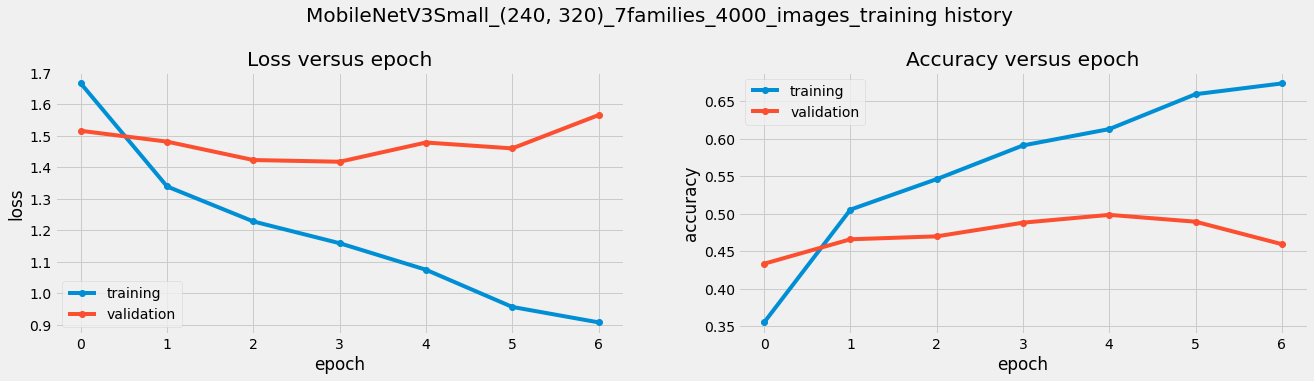

time: 422 ms (started: 2022-02-08 13:14:02 +01:00)


In [35]:
# save history 
pathinfos = 'MobileNetV3Small_(240, 320)_7families_4000_images'
hist_df3 = pd.DataFrame(training3_history.history)
hist_df3.to_csv(export_dir + pathinfos + '_history.csv')
training3_history_fig = plot_history(training3_history)
display(training3_history_fig)
# save fig 
training3_history_fig.savefig(export_dir + pathinfos +  '_training_history.jpeg' )

In [45]:
max(training3_history.history['val_accuracy'])

0.4986979067325592

time: 16 ms (started: 2022-02-08 13:37:25 +01:00)


In [37]:
#predict class 
start=time.time()
test_pred_class=[]
for i in range(8):
    test_pred_class_temp = model3.predict(test_data[i][0]).argmax(axis = 1) # predictions test
    test_pred_class=np.concatenate([test_pred_class,test_pred_class_temp])
end=time.time()
print('durée totale calcul :',end-start)

durée totale calcul : 12.467706680297852
time: 12.5 s (started: 2022-02-08 13:15:54 +01:00)


test_data[i][0]: group of images by batch of 32 images with i from 0 to 30 and only 8 images for i=31
Reason: total of 1000 images splitted by groups of 32 images => 31*32+8=1000
test_data[i][1]: label or family class of the group i

In [38]:
#assess performances
y_test_class=[]
for i in range(8):
    y_test_class=np.concatenate([y_test_class,test_data[i][1]])
print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

         0.0       0.50      0.60      0.54       147
         1.0       0.64      0.45      0.53       133
         2.0       0.68      0.70      0.69       169
         3.0       0.45      0.33      0.38       115
         4.0       0.55      0.53      0.54       171
         5.0       0.58      0.46      0.51       126
         6.0       0.41      0.61      0.49       139

    accuracy                           0.54      1000
   macro avg       0.54      0.53      0.53      1000
weighted avg       0.55      0.54      0.54      1000

time: 1.64 s (started: 2022-02-08 13:16:21 +01:00)


In [39]:
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + pathinfos + '_classification report.csv'
report.to_csv(report_path)

time: 0 ns (started: 2022-02-08 13:16:35 +01:00)


In [40]:
y_test_class_df=pd.DataFrame(y_test_class)
y_test_count=pd.DataFrame(y_test_class_df.value_counts(),columns=['y_test_count'])
y_test_count=y_test_count.sort_index()
test_dict_label=pd.DataFrame(test_data.class_indices,index=['label']).transpose()
test_dict_label['y_test_count']=y_test_count['y_test_count'].values
test_dict_label=test_dict_label.reset_index()
test_dict_label=test_dict_label.rename({'index':'gbif_info.family'},axis=1)
test_dict_label

,gbif_info.family,label,y_test_count
0,Agaricaceae,0,147
1,Amanitaceae,1,133
2,Boletaceae,2,169
3,Cortinariaceae,3,115
4,Russulaceae,4,171
5,Strophariaceae,5,126
6,Tricholomataceae,6,139


time: 15 ms (started: 2022-02-08 13:16:45 +01:00)


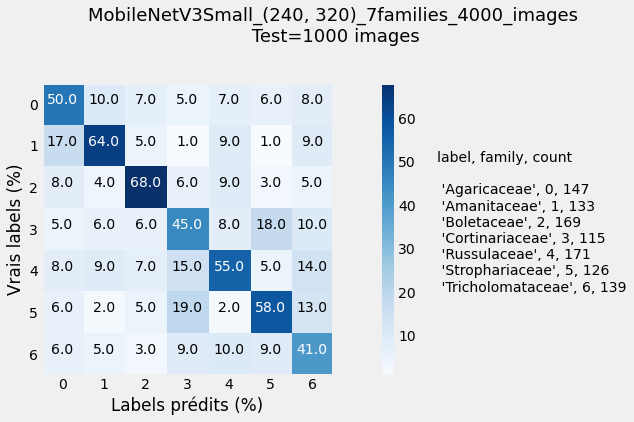

durée calcul[min]: 1616917236.3699374
*******************************************************************************************************************
*******************************************************************************************************************
*******************************************************************************************************************
*******************************************************************************************************************
time: 562 ms (started: 2022-02-08 13:16:50 +01:00)


In [41]:
# colored conf matrix  
classes = test_dict_label['gbif_info.family'].nunique()  # classes
# plot 
conf_matrix_fig = conf_matrix(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir + pathinfos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
end=time.time()
print('durée calcul[min]:',end-start//60)
print('*'*115)
print('*'*115)
print('*'*115)
print('*'*115)

MOBILENETV3SMALL with Bayesian optimization ON THE TOP7 FAMILIES (5000 images)

MODEL MobileNetV3Small+classification sur Top7families

In [47]:
def black_box_model(lr,dropout_rate1,dropout_rate2):
    base_model=MobileNetV3Small(weights='imagenet',include_top=False)
    for layer in base_model.layers: #freeze the base_model layers
        layer.trainable = False
    model4=Sequential()
    model4.add(base_model)
    model4.add(GlobalAveragePooling2D()) 
    model4.add(Dense(units = 1024, activation = 'relu'))
    model4.add(Dropout(dropout_rate1))
    model4.add(Dense(units = 512, activation = 'relu'))
    model4.add(Dropout(dropout_rate2))
    model3.add(Dense(units = 7, activation = 'softmax'))
#    model4.summary()
    model4.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    training4_history=model4.fit(training_data,validation_data=validation_data,epochs=20,
                                 steps_per_epoch=3203//128,
                                 validation_steps=797//128,callbacks=[early_stopping,lr_plateau])
    return max(training4_history.history['val_accuracy'])

time: 0 ns (started: 2022-02-08 13:38:03 +01:00)


In [48]:
from bayes_opt import BayesianOptimization
# Bounded region of parameter space
pbounds = {'lr':(1e-5,0.001), 'dropout_rate1':(0.1,0.5),'dropout_rate2':(0.1,0.5)}

optimizer = BayesianOptimization(
    f=black_box_model,
    pbounds=pbounds,
    random_state=1,
)

start = time.time()
optimizer.maximize(
    init_points=2,
    n_iter=3,
)
end = time.time() # timer end 
total_time=end-start
print('il faut {}min pour construire le model'.format(round(total_time/60,3)))

|   iter    |  target   | dropou... | dropou... |    lr     |
-------------------------------------------------------------
Epoch 1/20
25/25 [==============================] - 97s 4s/step - loss: 14.6730 - accuracy: 0.0075 - val_loss: 10.2103 - val_accuracy: 0.0169 - lr: 1.0113e-05
Epoch 2/20
25/25 [==============================] - 93s 4s/step - loss: 13.9473 - accuracy: 0.0120 - val_loss: 8.9569 - val_accuracy: 0.0247 - lr: 1.0113e-05
Epoch 3/20
25/25 [==============================] - 97s 4s/step - loss: 13.3160 - accuracy: 0.0206 - val_loss: 7.7346 - val_accuracy: 0.0404 - lr: 1.0113e-05
Epoch 4/20
25/25 [==============================] - 94s 4s/step - loss: 12.2927 - accuracy: 0.0286 - val_loss: 6.3004 - val_accuracy: 0.0625 - lr: 1.0113e-05
Epoch 5/20
25/25 [==============================] - 95s 4s/step - loss: 11.5474 - accuracy: 0.0478 - val_loss: 5.6633 - val_accuracy: 0.0898 - lr: 1.0113e-05
Epoch 6/20
25/25 [==============================] - 97s 4s/step - loss: 11.1376 - acc

25/25 [==============================] - 101s 4s/step - loss: 4.2287 - accuracy: 0.2072 - val_loss: 1.9454 - val_accuracy: 0.2214 - lr: 7.4374e-05
Epoch 7/20
25/25 [==============================] - 101s 4s/step - loss: 4.2949 - accuracy: 0.2068 - val_loss: 1.9661 - val_accuracy: 0.2240 - lr: 7.4374e-05
Epoch 8/20
25/25 [==============================] - 101s 4s/step - loss: 4.2749 - accuracy: 0.2117 - val_loss: 1.9477 - val_accuracy: 0.2161 - lr: 7.4374e-05
Epoch 9/20
25/25 [==============================] - ETA: 0s - loss: 4.4800 - accuracy: 0.2094
Epoch 00009: ReduceLROnPlateau reducing learning rate to 7.4373969507378516e-06.
25/25 [==============================] - 101s 4s/step - loss: 4.4800 - accuracy: 0.2094 - val_loss: 1.9477 - val_accuracy: 0.2227 - lr: 7.4374e-05
|  4        |  0.224    |  0.2234   |  0.1596   |  0.000743 |
Epoch 1/20
25/25 [==============================] - 106s 4s/step - loss: 5.0965 - accuracy: 0.2120 - val_loss: 1.9457 - val_accuracy: 0.2344 - lr: 7.9856

In [49]:
print(optimizer.max)

{'target': 0.2447916716337204, 'params': {'dropout_rate1': 0.22093302905273593, 'dropout_rate2': 0.15870235632684523, 'lr': 0.00010141520882110982}}
time: 16 ms (started: 2022-02-08 15:13:01 +01:00)


In [50]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.17578125, 'params': {'dropout_rate1': 0.2668088018810296, 'dropout_rate2': 0.38812979737686326, 'lr': 1.011323106917144e-05}}
Iteration 1: 
	{'target': 0.2447916716337204, 'params': {'dropout_rate1': 0.22093302905273593, 'dropout_rate2': 0.15870235632684523, 'lr': 0.00010141520882110982}}
Iteration 2: 
	{'target': 0.1731770783662796, 'params': {'dropout_rate1': 0.25033615230573336, 'dropout_rate2': 0.41595141401041025, 'lr': 0.0007767024330743346}}
Iteration 3: 
	{'target': 0.2239583283662796, 'params': {'dropout_rate1': 0.22338817927573726, 'dropout_rate2': 0.15955549375479344, 'lr': 0.0007437396950737851}}
Iteration 4: 
	{'target': 0.2356770783662796, 'params': {'dropout_rate1': 0.21538091855977437, 'dropout_rate2': 0.16166067707152704, 'lr': 0.0007985605117658491}}
time: 0 ns (started: 2022-02-08 15:14:45 +01:00)


In [51]:
print('*'*115)
print('*'*115)

*******************************************************************************************************************
*******************************************************************************************************************
time: 0 ns (started: 2022-02-08 15:18:18 +01:00)


MOBILENETV3SMALL with Bayesian optimization ON THE TOP7 FAMILIES (5000 images)
parameters: epochs & batch_size

In [64]:
def black_box_model2(factor):
    early_stopping=callbacks.EarlyStopping(monitor='val_loss',patience=4,mode='min',restore_best_weights=True)
    lr_plateau=callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=factor,verbose=2,mode='min',
                                       min_lr=1e-10)
    
    base_model=MobileNetV3Small(weights='imagenet',include_top=False)
    for layer in base_model.layers: #freeze the base_model layers
        layer.trainable = False
    model5=Sequential()
    model5.add(base_model)
    model5.add(GlobalAveragePooling2D()) 
    model5.add(Dense(units = 1024, activation = 'relu'))
    model5.add(Dropout(0.3))
    model5.add(Dense(units = 512, activation = 'relu'))
    model5.add(Dropout(0.2))
    model5.add(Dense(units = 7, activation = 'softmax'))
#    model5.summary()
    model5.compile(optimizer=Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    training5_history=model5.fit(training_data,
                                 validation_data=validation_data,
                                 epochs=20,
                                 steps_per_epoch=3203//128,
                                 validation_steps=797//128,
                                 callbacks=[early_stopping,lr_plateau])
    return max(training5_history.history['val_accuracy'])

time: 0 ns (started: 2022-02-08 16:23:45 +01:00)


In [65]:
pbounds2 = {'factor':(0.1,0.5)}
optimizer2 = BayesianOptimization(f=black_box_model2, pbounds=pbounds2, random_state=1,)

start = time.time()

optimizer2.probe(params={'factor':0.5}, lazy=True,)
optimizer2.probe(params=[0.4], lazy=True)
optimizer2.probe(params=[0.3], lazy=True)
optimizer2.probe(params=[0.2], lazy=True)
optimizer2.probe(params=[0.1], lazy=True)
# Will probe only the points specified above
optimizer2.maximize(init_points=0, n_iter=0)

end = time.time() # timer end 
total_time=end-start
print('il faut {}min pour construire le model'.format(round(total_time/60,3)))

|   iter    |  target   |  factor   |
-------------------------------------
Epoch 1/20
25/25 [==============================] - 100s 4s/step - loss: 1.6810 - accuracy: 0.3509 - val_loss: 1.5020 - val_accuracy: 0.4453 - lr: 0.0010
Epoch 2/20
25/25 [==============================] - 97s 4s/step - loss: 1.3391 - accuracy: 0.4963 - val_loss: 1.3920 - val_accuracy: 0.4714 - lr: 0.0010
Epoch 3/20
25/25 [==============================] - 99s 4s/step - loss: 1.2183 - accuracy: 0.5489 - val_loss: 1.4279 - val_accuracy: 0.4635 - lr: 0.0010
Epoch 4/20
25/25 [==============================] - ETA: 0s - loss: 1.1543 - accuracy: 0.5779
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
25/25 [==============================] - 99s 4s/step - loss: 1.1543 - accuracy: 0.5779 - val_loss: 1.4995 - val_accuracy: 0.4661 - lr: 0.0010
Epoch 5/20
25/25 [==============================] - 100s 4s/step - loss: 1.0128 - accuracy: 0.6332 - val_loss: 1.3760 - val_accuracy: 0.4948 - lr: 5

25/25 [==============================] - ETA: 0s - loss: 1.1556 - accuracy: 0.5880
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
25/25 [==============================] - 100s 4s/step - loss: 1.1556 - accuracy: 0.5880 - val_loss: 1.4324 - val_accuracy: 0.4727 - lr: 0.0010
Epoch 5/20
25/25 [==============================] - 100s 4s/step - loss: 1.0485 - accuracy: 0.6176 - val_loss: 1.3994 - val_accuracy: 0.4857 - lr: 1.0000e-04
Epoch 6/20
25/25 [==============================] - 100s 4s/step - loss: 0.9856 - accuracy: 0.6410 - val_loss: 1.3800 - val_accuracy: 0.4948 - lr: 1.0000e-04
Epoch 7/20
25/25 [==============================] - 100s 4s/step - loss: 0.9796 - accuracy: 0.6475 - val_loss: 1.4101 - val_accuracy: 0.4766 - lr: 1.0000e-04
Epoch 8/20
25/25 [==============================] - ETA: 0s - loss: 0.9577 - accuracy: 0.6514
Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
25/25 [==============================] - 100

In [66]:
print(optimizer2.max)

{'target': 0.5143229365348816, 'params': {'factor': 0.4}}
time: 0 ns (started: 2022-02-08 17:43:08 +01:00)


In [67]:
for i, res in enumerate(optimizer2.res):
    print("Iteration {}: \n\t{}".format(i, res))

Iteration 0: 
	{'target': 0.5104166865348816, 'params': {'factor': 0.5}}
Iteration 1: 
	{'target': 0.5143229365348816, 'params': {'factor': 0.4}}
Iteration 2: 
	{'target': 0.5143229365348816, 'params': {'factor': 0.3}}
Iteration 3: 
	{'target': 0.5013020634651184, 'params': {'factor': 0.2}}
Iteration 4: 
	{'target': 0.5143229365348816, 'params': {'factor': 0.1}}
time: 0 ns (started: 2022-02-08 17:43:31 +01:00)


Meilleur val_accuracy à 0.5143 atteint le plus rapidement avec factor =0.4 (epoch n°8)

In [68]:
print('*'*115)
print('*'*115)

*******************************************************************************************************************
*******************************************************************************************************************
time: 0 ns (started: 2022-02-08 17:50:45 +01:00)


MOBILENETV3SMALL ON THE COMPLETE TOP7 FAMILIES (35787 images)
Reasons:
- best compromise between execution time and performances (loss and accuracy) => from Sebastien's results
- comparison between batch_size=32 versus batch_size=100 images

Conclusion: results slightly better with the batch_size=100.
Models 4,5 &6  trained on 22905 images + validated on 5722 images and prediction done on 7156 images
- f1_score=0.61 on the 7156 images of Test with batch_size=32
- f1_score=0.61 on the 7156 images of Test with batch_size=100
- f1_score=0.60 on the 7156 images of Test with batch_size=128

In [69]:
training_data=train_data_generator.flow_from_directory(directory=root_dir+'Top7families_imgs/Train/',
                                                       target_size=(240,320),class_mode='sparse',
                                                       batch_size=128,subset="training")
validation_data=train_data_generator.flow_from_directory(directory=root_dir+'Top7families_imgs/Train/',
                                                       target_size=(240,320),class_mode='sparse',
                                                       batch_size=128,subset="validation")
test_data=test_data_generator.flow_from_directory(directory=root_dir+'Top7families_imgs/Test/',
                                                  target_size=(240,320),class_mode='sparse',
                                                  batch_size=128)

Found 22905 images belonging to 7 classes.
Found 5722 images belonging to 7 classes.
Found 7156 images belonging to 7 classes.
time: 1.76 s (started: 2022-02-08 17:51:22 +01:00)


In [70]:
from tensorflow.keras.applications import MobileNetV3Small
early_stopping=callbacks.EarlyStopping(monitor='val_loss',patience=4,mode='min',restore_best_weights=True)
lr_plateau=callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.4,verbose=2,mode='min',
                                       min_lr=1e-10)

base_model=MobileNetV3Small(weights='imagenet',include_top=False)
for layer in base_model.layers: #freeze the base_model layers
    layer.trainable = False
model6=Sequential()
model6.add(base_model)
model6.add(GlobalAveragePooling2D()) 
model6.add(Dense(units = 1024, activation = 'relu'))
model6.add(Dropout(0.3))
model6.add(Dense(units = 512, activation = 'relu'))
model6.add(Dropout(0.2))
model6.add(Dense(units = 7, activation = 'softmax'))
model6.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling2d_33  (None, 1024)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_48 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout_32 (Dropout)        (None, 1024)              0         
                                                                 
 dense_49 (Dense)            (None, 512)               524800    
                                                                 
 dropout_33 (Dropout)        (None, 512)             

In [71]:
model6.compile(optimizer=Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

time: 0 ns (started: 2022-02-08 17:54:15 +01:00)


In [72]:
start = time.time()
training6_history=model6.fit(training_data,validation_data=validation_data,epochs=20,
                             steps_per_epoch=22905//128,
                             validation_steps=5722//128,callbacks=[early_stopping,lr_plateau])
end = time.time()
total_time = end-start
print('il faut {}min pour construire le model'.format(round(total_time/60,3)))

Epoch 1/20
178/178 [==============================] - 841s 5s/step - loss: 1.3676 - accuracy: 0.4941 - val_loss: 1.2468 - val_accuracy: 0.5419 - lr: 0.0010
Epoch 2/20
178/178 [==============================] - 723s 4s/step - loss: 1.1753 - accuracy: 0.5709 - val_loss: 1.2000 - val_accuracy: 0.5652 - lr: 0.0010
Epoch 3/20
178/178 [==============================] - 725s 4s/step - loss: 1.0907 - accuracy: 0.6017 - val_loss: 1.1856 - val_accuracy: 0.5657 - lr: 0.0010
Epoch 4/20
178/178 [==============================] - 720s 4s/step - loss: 1.0328 - accuracy: 0.6225 - val_loss: 1.1674 - val_accuracy: 0.5753 - lr: 0.0010
Epoch 5/20
178/178 [==============================] - 725s 4s/step - loss: 0.9831 - accuracy: 0.6428 - val_loss: 1.1655 - val_accuracy: 0.5835 - lr: 0.0010
Epoch 6/20
178/178 [==============================] - 724s 4s/step - loss: 0.9414 - accuracy: 0.6593 - val_loss: 1.1600 - val_accuracy: 0.5813 - lr: 0.0010
Epoch 7/20
178/178 [==============================] - 722s 4s/st

In [73]:
# export dir with time stamp
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

C:/Users/sioha/Projet_mushroom/Deep_learning/220208_20H10/
time: 0 ns (started: 2022-02-08 20:10:54 +01:00)


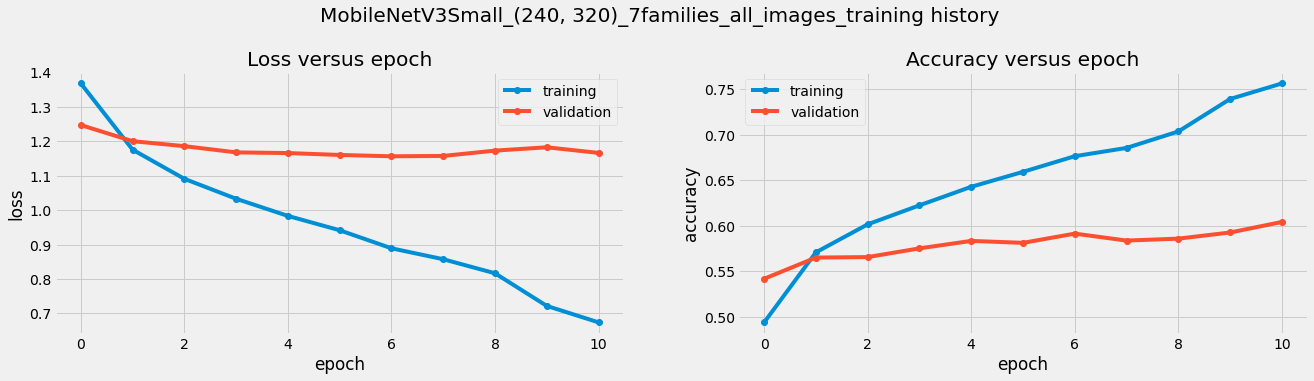

time: 359 ms (started: 2022-02-08 20:11:17 +01:00)


In [75]:
# save history 
pathinfos = 'MobileNetV3Small_(240, 320)_7families_all_images'
hist_df6 = pd.DataFrame(training6_history.history)
hist_df6.to_csv(export_dir + pathinfos + '_history.csv')
training6_history_fig = plot_history(training6_history)
display(training6_history_fig)
# save fig 
training6_history_fig.savefig(export_dir + pathinfos +  '_training_history.jpeg' )

In [76]:
#assess performances 
start=time.time()
test_pred_class=[]
for i in range(56):
    test_pred_class_temp = model6.predict(test_data[i][0]).argmax(axis = 1) # predictions test
    test_pred_class=np.concatenate([test_pred_class,test_pred_class_temp])
end=time.time()
total_time=end-start
print('durée totale calcul :',total_time)

durée totale calcul : 123.18169045448303
time: 2min 3s (started: 2022-02-08 20:12:09 +01:00)


In [77]:
#confusion matrix
y_test_class=[]
for i in range(56):
    y_test_class=np.concatenate([y_test_class,test_data[i][1]])
print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

         0.0       0.59      0.64      0.61      1049
         1.0       0.64      0.72      0.67       954
         2.0       0.74      0.72      0.73      1212
         3.0       0.61      0.33      0.43       825
         4.0       0.58      0.67      0.62      1224
         5.0       0.60      0.52      0.56       899
         6.0       0.45      0.51      0.48       993

    accuracy                           0.60      7156
   macro avg       0.60      0.59      0.59      7156
weighted avg       0.60      0.60      0.60      7156

time: 11.8 s (started: 2022-02-08 20:15:13 +01:00)


In [78]:
# save report
report = metrics.classification_report(y_test_class, test_pred_class, output_dict=True)
report = pd.DataFrame(report).transpose()
report_path = export_dir + pathinfos + '_classification report.csv'
report.to_csv(report_path)

time: 31 ms (started: 2022-02-08 20:15:37 +01:00)


In [79]:
y_test_class_df=pd.DataFrame(y_test_class)
y_test_count=pd.DataFrame(y_test_class_df.value_counts(),columns=['y_test_count'])
y_test_count=y_test_count.sort_index()
test_dict_label=pd.DataFrame(test_data.class_indices,index=['label']).transpose()
test_dict_label['y_test_count']=y_test_count['y_test_count'].values
test_dict_label=test_dict_label.reset_index()
test_dict_label=test_dict_label.rename({'index':'gbif_info.family'},axis=1)
test_dict_label

,gbif_info.family,label,y_test_count
0,Agaricaceae,0,1049
1,Amanitaceae,1,954
2,Boletaceae,2,1212
3,Cortinariaceae,3,825
4,Russulaceae,4,1224
5,Strophariaceae,5,899
6,Tricholomataceae,6,993


time: 31 ms (started: 2022-02-08 20:15:41 +01:00)


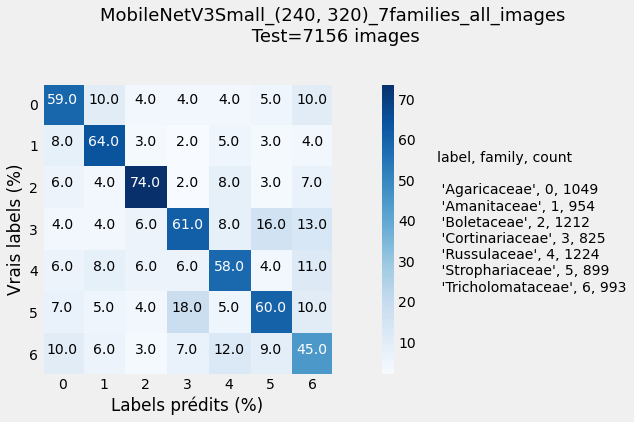

*******************************************************************************************************************
*******************************************************************************************************************
*******************************************************************************************************************
*******************************************************************************************************************
time: 1.81 s (started: 2022-02-08 20:15:48 +01:00)


In [80]:
#colored conf matrix  
classes = test_dict_label['gbif_info.family'].nunique()  # classes
# plot 
conf_matrix_fig = conf_matrix(y_test_class , test_pred_class,classes,test_dict_label)
display(conf_matrix_fig)
# save fig 
conf_matrix_fig.savefig(export_dir + pathinfos +  '_conf_matrix.jpeg' ,bbox_inches = 'tight')
print('*'*115)
print('*'*115)
print('*'*115)
print('*'*115)